In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/new_version_data.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [3]:
import collections
orderedDict = collections.OrderedDict()


from collections import OrderedDict
import pprint

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import cv2
np.random.seed = 42


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [7]:
%env SM_FRAMEWORK=tf.keras

!pip install segmentation_models

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

env: SM_FRAMEWORK=tf.keras
     |████████████████████████████████| 51kB 3.4MB/s 
Segmentation Models: using `tf.keras` framework.


In [8]:
from keras import backend as K

def jacard_coef(y_true,y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  intersection = K.sum(y_true_f*y_pred_f)
  return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)
  
def jacard_loss(y_true,y_pred):
  return -jacard_coef(y_true,y_pred)

In [9]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras


In [10]:
os.listdir('dataset/new_version_data/PLDM')

['aug_images', 'masks', 'images', 'aug_masks']

# PLDU data set

## Data Import

In [11]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH_x = 'dataset/new_version_data/PLDU/aug_images'
TRAIN_PATH_y = 'dataset/new_version_data/PLDU/aug_masks'
# TEST_PATH = 'stage1_test/'
sub_feat = sorted(os.listdir(TRAIN_PATH_x))
sub_label = sorted(os.listdir(TRAIN_PATH_y))
# train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(sub_feat), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(sub_label), IMG_HEIGHT, IMG_WIDTH,1),dtype = np.uint8)


In [12]:
for i in range(len(sub_feat)):
    img = imread(TRAIN_PATH_x+'/'+sub_feat[i])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    
    img2 = imread(TRAIN_PATH_y+'/'+sub_label[i])
    img2 = resize(img2, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[i] = img2[:,:,1].reshape(img2[:,:,1].shape[0],img2[:,:,1].shape[1],1)

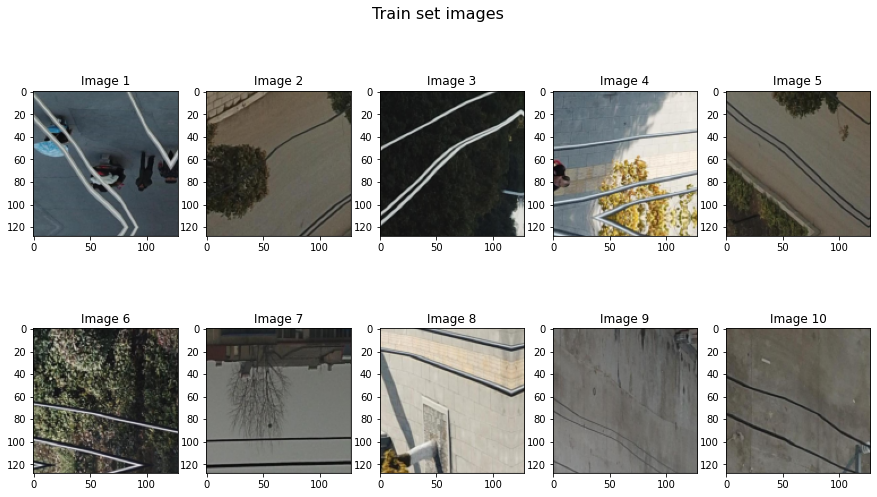

In [13]:
f, axarr = plt.subplots(2,5,figsize=(15,8))
axarr[0,0].imshow(X_train[0])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(X_train[1])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(X_train[2])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(X_train[3])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(X_train[4])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(X_train[5])
axarr[1,0].set_title('Image 6')
axarr[1,1].imshow(X_train[6])
axarr[1,1].set_title('Image 7')
axarr[1,2].imshow(X_train[7])
axarr[1,2].set_title('Image 8')
axarr[1,3].imshow(X_train[8])
axarr[1,3].set_title('Image 9')
axarr[1,4].imshow(X_train[9])
axarr[1,4].set_title('Image 10')
f.suptitle('Train set images', fontsize=16)
plt.show()

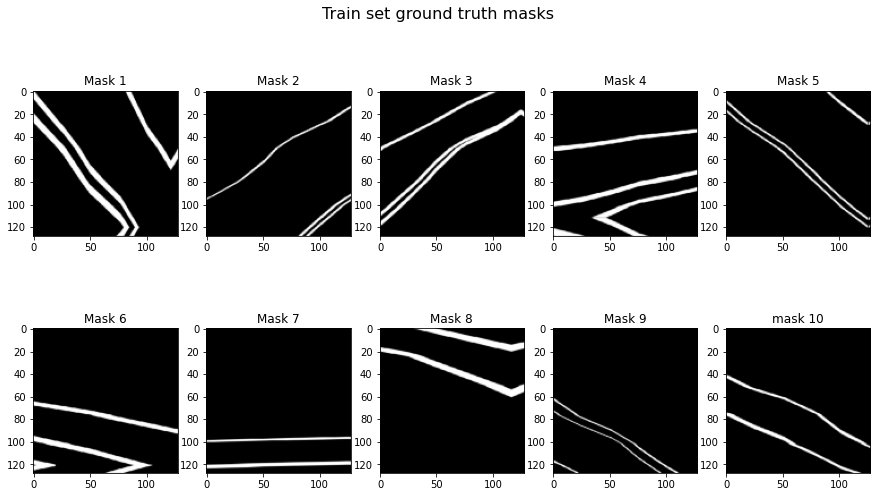

In [14]:
f, axarr = plt.subplots(2,5,figsize=(15,8))
axarr[0,0].imshow(Y_train[0][:,:,0],cmap='gray')
axarr[0,0].set_title('Mask 1')
axarr[0,1].imshow(Y_train[1][:,:,0],cmap='gray')
axarr[0,1].set_title('Mask 2')
axarr[0,2].imshow(Y_train[2][:,:,0],cmap='gray')
axarr[0,2].set_title('Mask 3')
axarr[0,3].imshow(Y_train[3][:,:,0],cmap='gray')
axarr[0,3].set_title('Mask 4')
axarr[0,4].imshow(Y_train[4][:,:,0],cmap='gray')
axarr[0,4].set_title('Mask 5')
axarr[1,0].imshow(Y_train[5][:,:,0],cmap='gray')
axarr[1,0].set_title('Mask 6')
axarr[1,1].imshow(Y_train[6][:,:,0],cmap='gray')
axarr[1,1].set_title('Mask 7')
axarr[1,2].imshow(Y_train[7][:,:,0],cmap='gray')
axarr[1,2].set_title('Mask 8')
axarr[1,3].imshow(Y_train[8][:,:,0],cmap='gray')
axarr[1,3].set_title('Mask 9')
axarr[1,4].imshow(Y_train[9][:,:,0],cmap='gray')
axarr[1,4].set_title('mask 10')
f.suptitle('Train set ground truth masks', fontsize=16)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
Y_train = Y_train / 255.
X_train = X_train / 255.


train_x,val_x,train_y,val_y = train_test_split(X_train,Y_train,test_size = 0.25) 

## Training the U-Net model

### VGG 16

In [16]:
BACKBONE = 'vgg16'

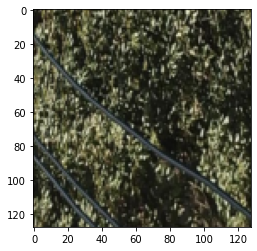

In [17]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [18]:
model_unet_vgg = 'models/unet_vgg'

In [19]:
num_thresholds = 15
model = sm.Unet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_unet_vgg, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

58892288/58889256 [==============================] - 3s 0us/step
Epoch 1/50
75/75 [==============================] - 63s 356ms/step - loss: 0.2619 - auc: 0.8363 - val_loss: 0.2239 - val_auc: 0.9069

Epoch 00001: val_loss improved from inf to 0.22386, saving model to models/unet_vgg
Epoch 2/50
75/75 [==============================] - 23s 311ms/step - loss: 0.0841 - auc: 0.9723 - val_loss: 0.1071 - val_auc: 0.9711

Epoch 00002: val_loss improved from 0.22386 to 0.10715, saving model to models/unet_vgg
Epoch 3/50
75/75 [==============================] - 23s 311ms/step - loss: 0.0686 - auc: 0.9815 - val_loss: 0.2721 - val_auc: 0.5346

Epoch 00003: val_loss did not improve from 0.10715
Epoch 4/50
75/75 [==============================] - 23s 313ms/step - loss: 0.0620 - auc: 0.9855 - val_loss: 0.0658 - val_auc: 0.9826

Epoch 00004: val_loss improved from 0.10715 to 0.06584, saving model to models/unet_vgg
Epoch 5/50
75/75 [==============================] - 23s 313ms/step - loss: 0.0572 - auc:

In [20]:
  model.load_weights(model_unet_vgg)

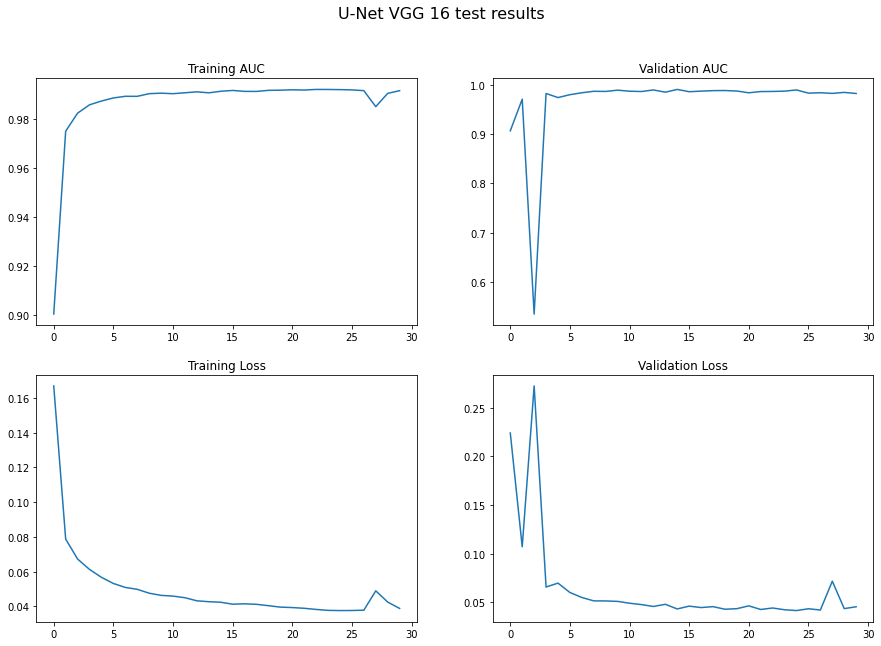

In [21]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('U-Net VGG 16 test results', fontsize=16)
plt.show()

In [22]:
tst_vgg = model.predict(val_x)

In [23]:
idx = np.random.choice(range(len(val_x)),5)

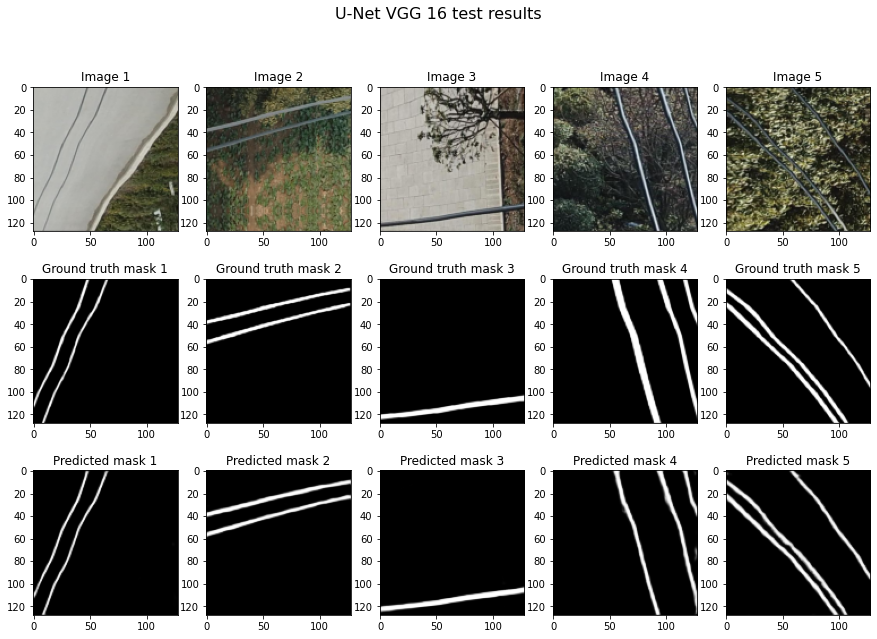

In [24]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net VGG 16 test results', fontsize=16)
plt.show()

In [25]:
num_thresholds = 20
thresholds = [(i + 1) * 1.0 / (num_thresholds - 1) for i in range(num_thresholds - 2)]

In [26]:
vgg_ious = []

for i in thresholds:
  cpy = tst_vgg.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  vgg_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [27]:
threshold = thresholds[np.argmax(vgg_ious)]

In [28]:
af_tst_vgg = tst_vgg.copy()
af_tst_vgg[af_tst_vgg >= threshold ] = 1
af_tst_vgg[af_tst_vgg < threshold ] = 0

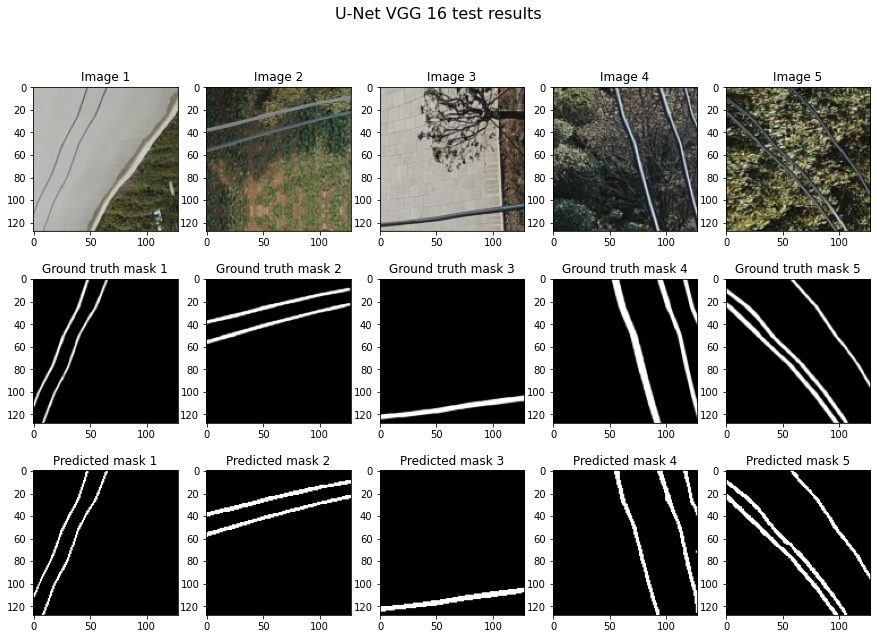

In [29]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net VGG 16 test results', fontsize=16)
plt.show()

In [30]:
print('IoU score for the U-Net VGG-16 backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_vgg))))

IoU score for the U-Net VGG-16 backbone is: 0.716158390045166 


### ResNet 34

In [39]:
BACKBONE = 'resnet34'

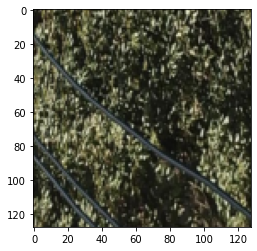

In [40]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [41]:
model_unet_resnet = 'models/unet_resnet'

In [42]:
# num_thresholds = 20
model = sm.Unet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(model_unet_resnet, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

Epoch 1/50
75/75 [==============================] - 27s 287ms/step - loss: 0.2622 - auc: 0.8051 - val_loss: 0.7166 - val_auc: 0.4772

Epoch 00001: val_loss improved from inf to 0.71655, saving model to models/unet_resnet
Epoch 2/50
75/75 [==============================] - 20s 272ms/step - loss: 0.0836 - auc: 0.9730 - val_loss: 0.2542 - val_auc: 0.4825

Epoch 00002: val_loss improved from 0.71655 to 0.25416, saving model to models/unet_resnet
Epoch 3/50
75/75 [==============================] - 20s 272ms/step - loss: 0.0681 - auc: 0.9826 - val_loss: 0.2945 - val_auc: 0.4590

Epoch 00003: val_loss did not improve from 0.25416
Epoch 4/50
75/75 [==============================] - 20s 272ms/step - loss: 0.0616 - auc: 0.9866 - val_loss: 0.3076 - val_auc: 0.4834

Epoch 00004: val_loss did not improve from 0.25416
Epoch 5/50
75/75 [==============================] - 20s 272ms/step - loss: 0.0564 - auc: 0.9896 - val_loss: 0.3497 - val_auc: 0.4980

Epoch 00005: val_loss did not improve from 0.25416

In [43]:
 model.load_weights(model_unet_resnet)

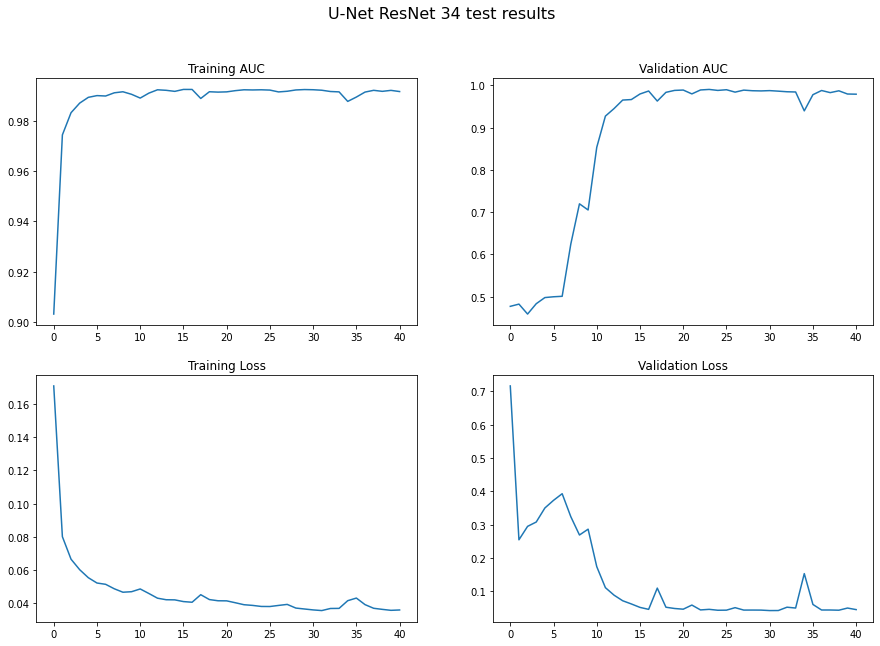

In [44]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('U-Net ResNet 34 test results', fontsize=16)
plt.show()

In [45]:
tst_resnet = model.predict(val_x)

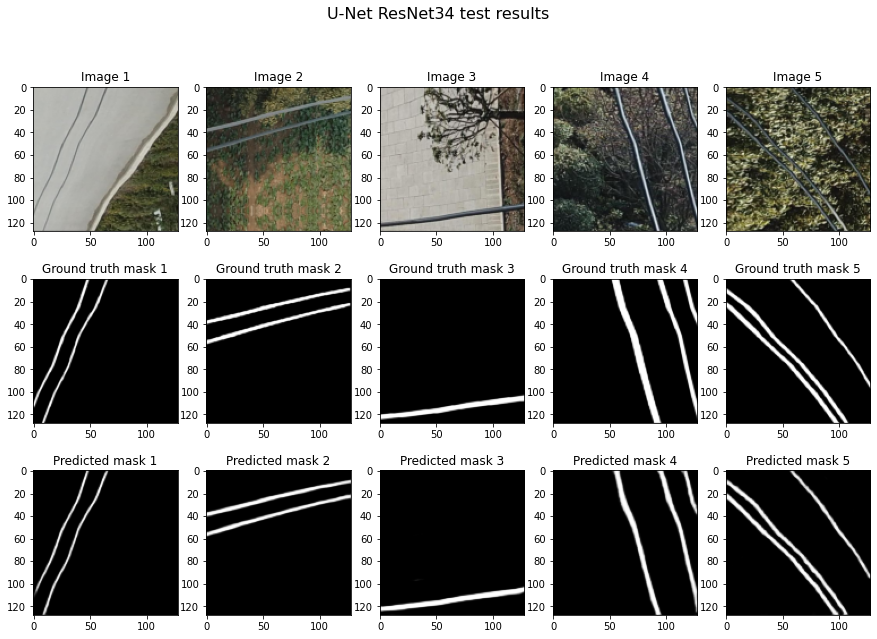

In [46]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_resnet[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_resnet[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_resnet[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_resnet[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_resnet[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net ResNet34 test results', fontsize=16)
plt.show()

In [47]:
resnet_ious = []

for i in thresholds:
  cpy = tst_resnet.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  resnet_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [48]:
threshold = thresholds[np.argmax(resnet_ious)]

In [49]:
af_tst_resnet = tst_resnet.copy()
af_tst_resnet[af_tst_resnet >= threshold ] = 1
af_tst_resnet[af_tst_resnet < threshold ] = 0

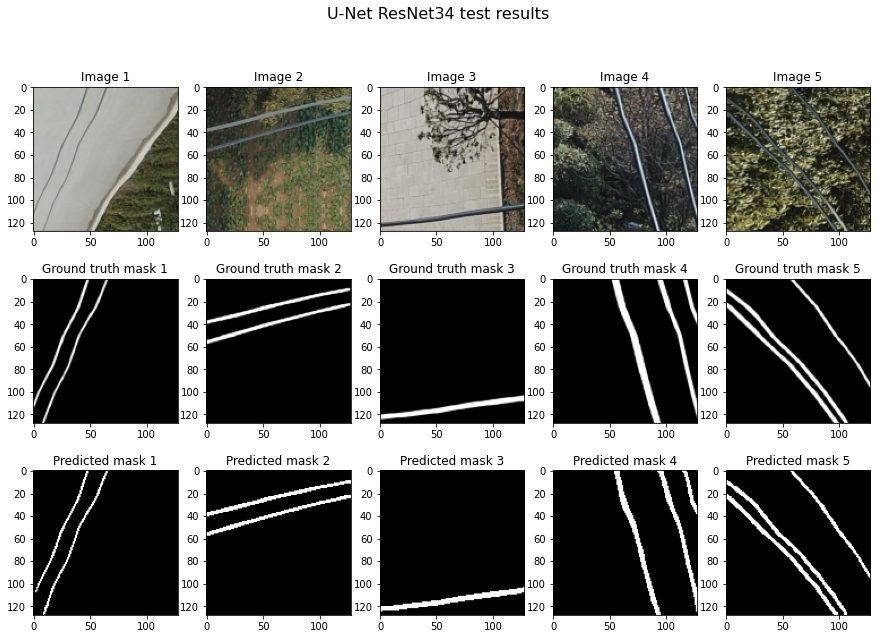

In [50]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_resnet[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_resnet[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_resnet[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_resnet[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_resnet[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net ResNet34 test results', fontsize=16)
plt.show()

In [51]:
print('IoU score for the ResNet 34  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_resnet))))

IoU score for the ResNet 34  backbone is: 0.7194108366966248 


### Inception V3

In [52]:
BACKBONE = 'inceptionv3'

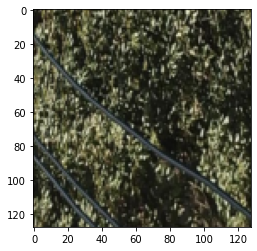

In [53]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [54]:
model_unet_inception = 'models/unet_inception'

In [55]:
# num_thresholds = 15
model = sm.Unet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_unet_inception, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

87916544/87910968 [==============================] - 3s 0us/step
Epoch 1/50
75/75 [==============================] - 42s 398ms/step - loss: 0.3220 - auc: 0.8501 - val_loss: 16.1500 - val_auc: 0.7292

Epoch 00001: val_loss improved from inf to 16.15001, saving model to models/unet_inception
Epoch 2/50
75/75 [==============================] - 27s 357ms/step - loss: 0.0820 - auc: 0.9762 - val_loss: 0.0853 - val_auc: 0.9718

Epoch 00002: val_loss improved from 16.15001 to 0.08533, saving model to models/unet_inception
Epoch 3/50
75/75 [==============================] - 27s 358ms/step - loss: 0.0624 - auc: 0.9858 - val_loss: 0.0909 - val_auc: 0.9697

Epoch 00003: val_loss did not improve from 0.08533
Epoch 4/50
75/75 [==============================] - 27s 357ms/step - loss: 0.0544 - auc: 0.9899 - val_loss: 0.0622 - val_auc: 0.9898

Epoch 00004: val_loss improved from 0.08533 to 0.06224, saving model to models/unet_inception
Epoch 5/50
75/75 [==============================] - 27s 357ms/step 

In [56]:
model.load_weights(model_unet_inception)

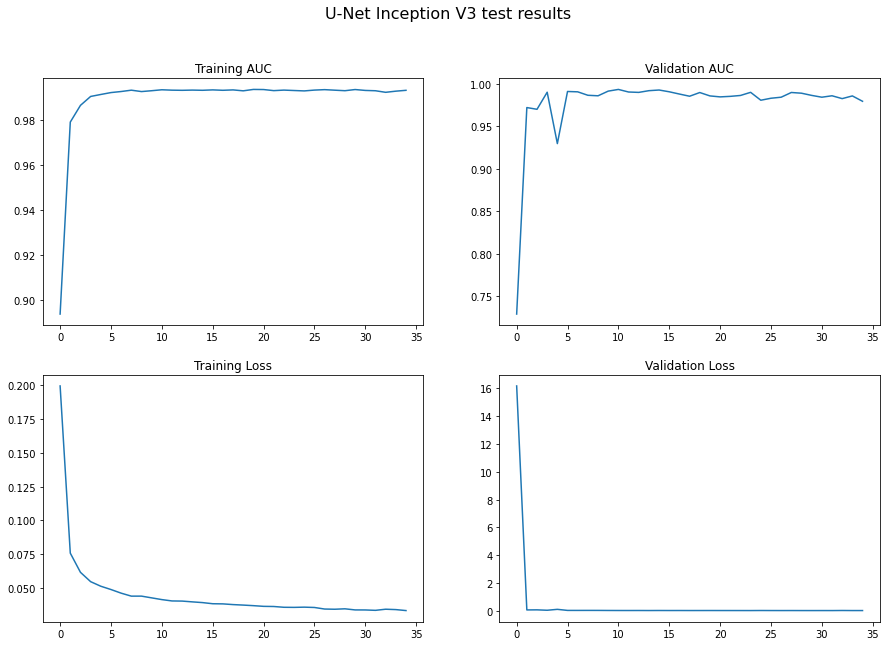

In [57]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('U-Net Inception V3 test results', fontsize=16)
plt.show()

In [58]:
tst_inception = model.predict(val_x)

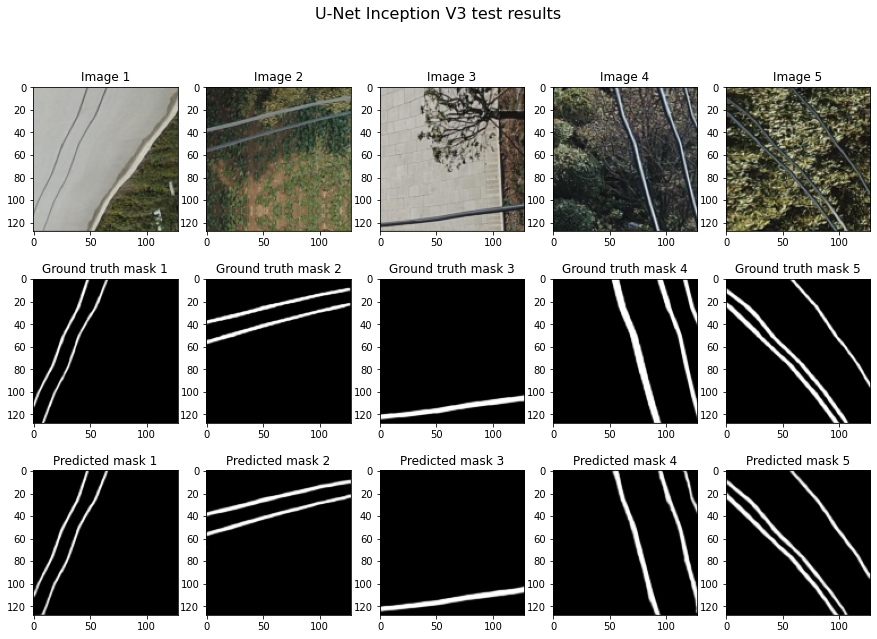

In [59]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net Inception V3 test results', fontsize=16)
plt.show()

In [60]:
inception_ious = []

for i in thresholds:
  cpy = tst_inception.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  inception_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [61]:
threshold = thresholds[np.argmax(inception_ious)]

In [62]:
af_tst_inception = tst_inception.copy()
af_tst_inception[af_tst_inception >= threshold ] = 1
af_tst_inception[af_tst_inception < threshold ] = 0

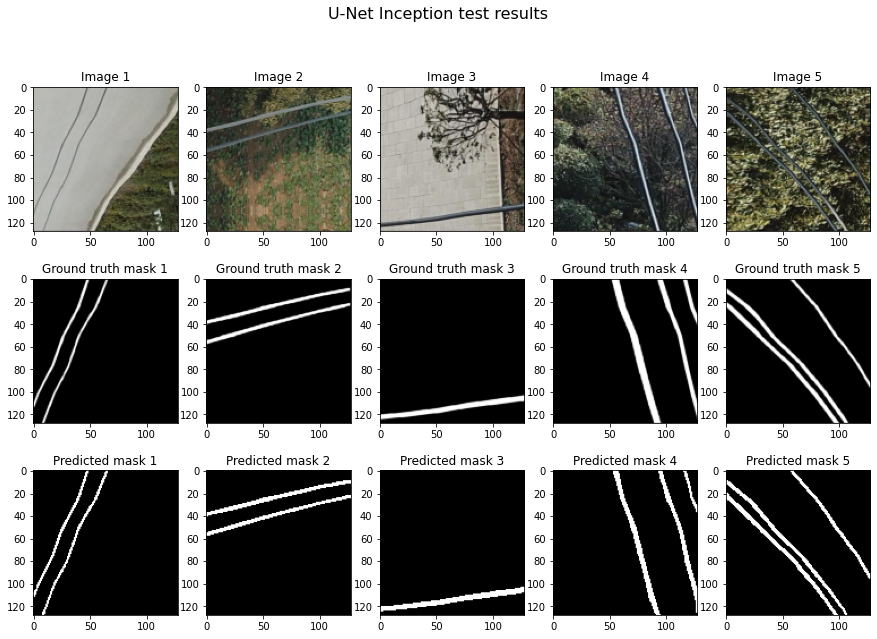

In [63]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net Inception test results', fontsize=16)
plt.show()

In [64]:
print('IoU score for the ResNet 34  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_inception))))

IoU score for the ResNet 34  backbone is: 0.7304558157920837 


#### Conclusion about U-Net model
Best backbone: **Inception V3** \\
Reason: Higher IoU

## LinkNet model

### VGG 16

In [65]:
BACKBONE = 'vgg16'

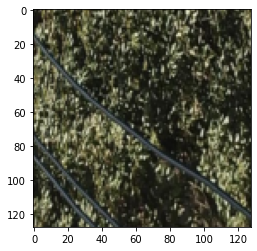

In [66]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [67]:
model_linknet_vgg = 'models/pldu/linknet_vgg'

In [68]:
# num_thresholds = 15
model = sm.Linknet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_linknet_vgg, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

Epoch 1/50
75/75 [==============================] - 28s 318ms/step - loss: 0.2974 - auc: 0.8380 - val_loss: 0.5429 - val_auc: 0.8707

Epoch 00001: val_loss improved from inf to 0.54294, saving model to models/pldu/linknet_vgg
Epoch 2/50
75/75 [==============================] - 23s 302ms/step - loss: 0.0839 - auc: 0.9684 - val_loss: 0.1226 - val_auc: 0.9683

Epoch 00002: val_loss improved from 0.54294 to 0.12261, saving model to models/pldu/linknet_vgg
Epoch 3/50
75/75 [==============================] - 23s 302ms/step - loss: 0.0727 - auc: 0.9777 - val_loss: 0.0901 - val_auc: 0.9585

Epoch 00003: val_loss improved from 0.12261 to 0.09005, saving model to models/pldu/linknet_vgg
Epoch 4/50
75/75 [==============================] - 23s 303ms/step - loss: 0.0637 - auc: 0.9815 - val_loss: 0.0845 - val_auc: 0.9538

Epoch 00004: val_loss improved from 0.09005 to 0.08452, saving model to models/pldu/linknet_vgg
Epoch 5/50
75/75 [==============================] - 23s 304ms/step - loss: 0.0593 - 

In [69]:
model.load_weights(model_linknet_vgg)

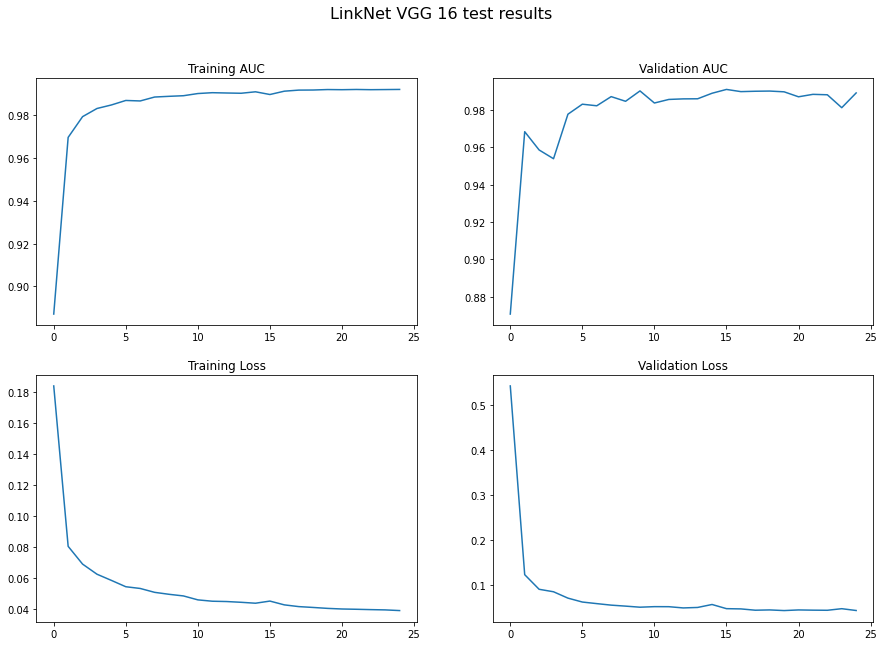

In [70]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('LinkNet VGG 16 test results', fontsize=16)
plt.show()

In [71]:
tst_vgg = model.predict(val_x)

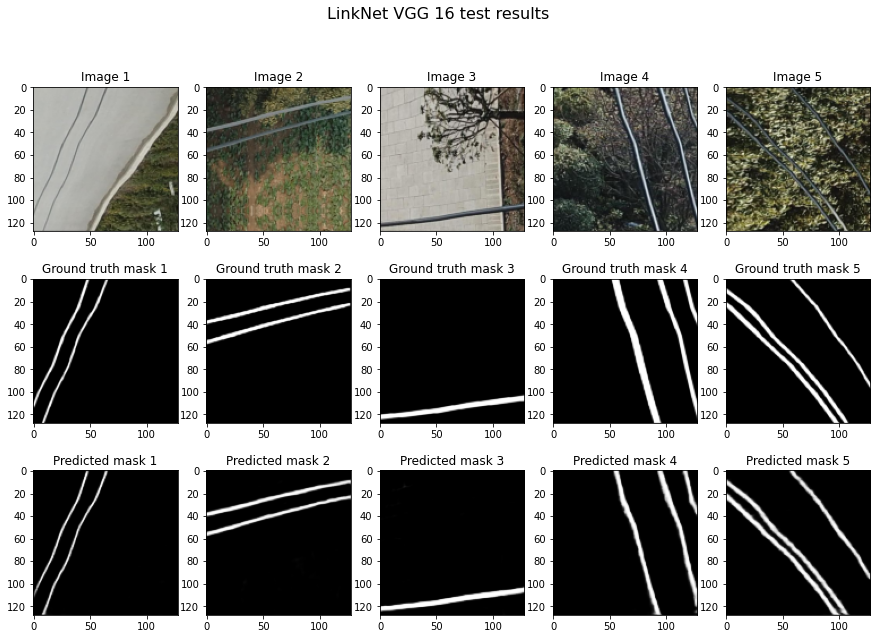

In [72]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('LinkNet VGG 16 test results', fontsize=16)
plt.show()

In [73]:
vgg_ious = []

for i in thresholds:
  cpy = tst_vgg.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  vgg_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [74]:
threshold = thresholds[np.argmax(vgg_ious)]

In [75]:
af_tst_vgg = tst_vgg.copy()
af_tst_vgg[af_tst_vgg >= threshold ] = 1
af_tst_vgg[af_tst_vgg < threshold ] = 0

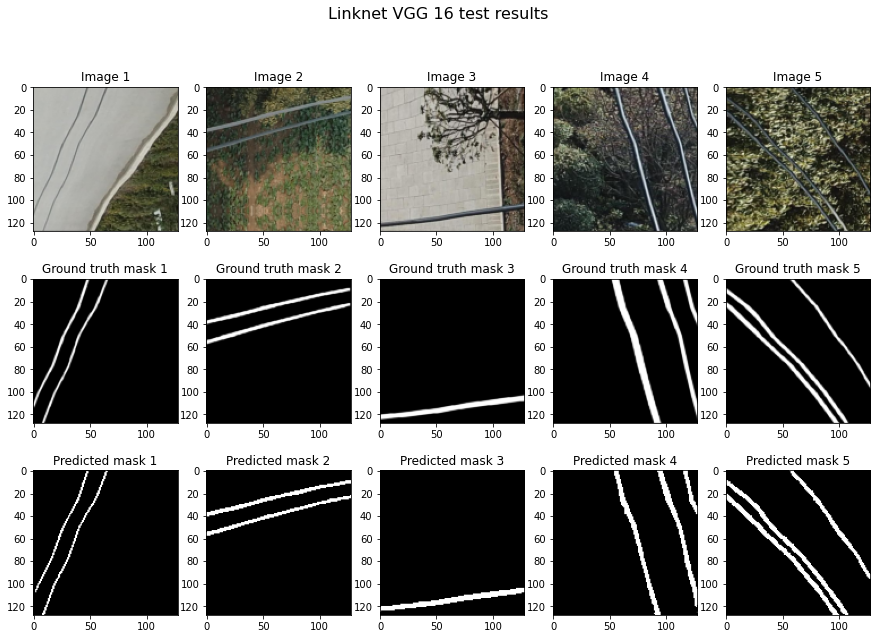

In [76]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('Linknet VGG 16 test results', fontsize=16)
plt.show()

In [77]:
print('IoU score for the LinkNet VGG-16 backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_vgg))))

IoU score for the LinkNet VGG-16 backbone is: 0.7069879174232483 


### ResNet 34

In [78]:
BACKBONE = 'resnet34'

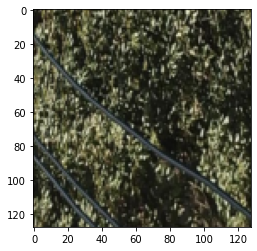

In [79]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [80]:
model_linknet_resnet = 'models/linknet_resnet'

In [81]:
num_thresholds = 15
model = sm.Linknet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(model_linknet_resnet, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

Epoch 1/50
75/75 [==============================] - 26s 260ms/step - loss: 0.2976 - auc: 0.6664 - val_loss: 0.2901 - val_auc: 0.4496

Epoch 00001: val_loss improved from inf to 0.29008, saving model to models/linknet_resnet
Epoch 2/50
75/75 [==============================] - 18s 243ms/step - loss: 0.0948 - auc: 0.9728 - val_loss: 0.2577 - val_auc: 0.5174

Epoch 00002: val_loss improved from 0.29008 to 0.25770, saving model to models/linknet_resnet
Epoch 3/50
75/75 [==============================] - 18s 244ms/step - loss: 0.0755 - auc: 0.9828 - val_loss: 0.2825 - val_auc: 0.5082

Epoch 00003: val_loss did not improve from 0.25770
Epoch 4/50
75/75 [==============================] - 18s 239ms/step - loss: 0.0652 - auc: 0.9859 - val_loss: 0.3437 - val_auc: 0.4947

Epoch 00004: val_loss did not improve from 0.25770
Epoch 5/50
75/75 [==============================] - 18s 245ms/step - loss: 0.0614 - auc: 0.9866 - val_loss: 0.3724 - val_auc: 0.4966

Epoch 00005: val_loss did not improve from 0

In [82]:
model.load_weights(model_linknet_resnet)

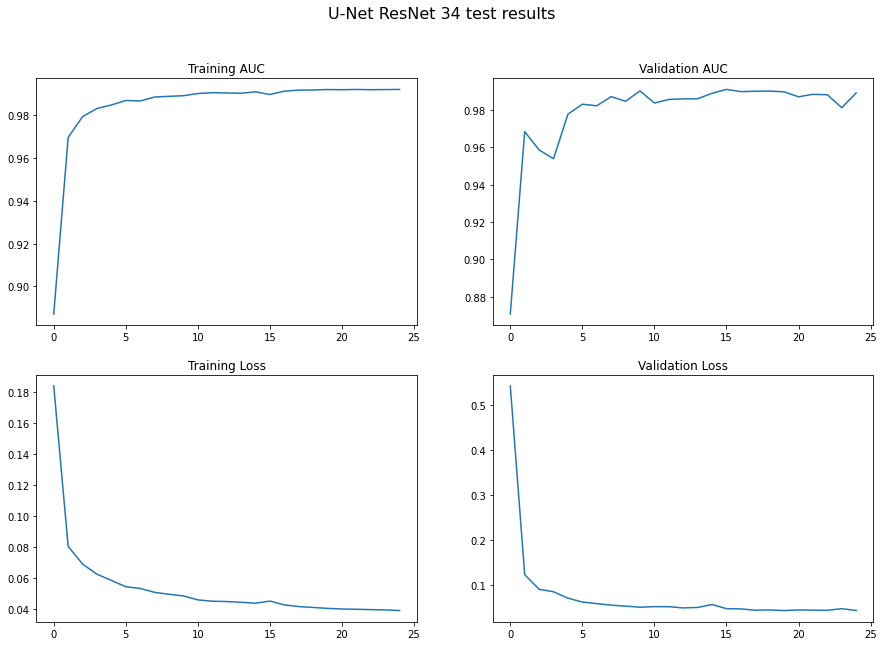

In [83]:
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('LinkNet ResNet 34 test results', fontsize=16)
plt.show()

In [84]:
tst_resnet = model.predict(val_x)

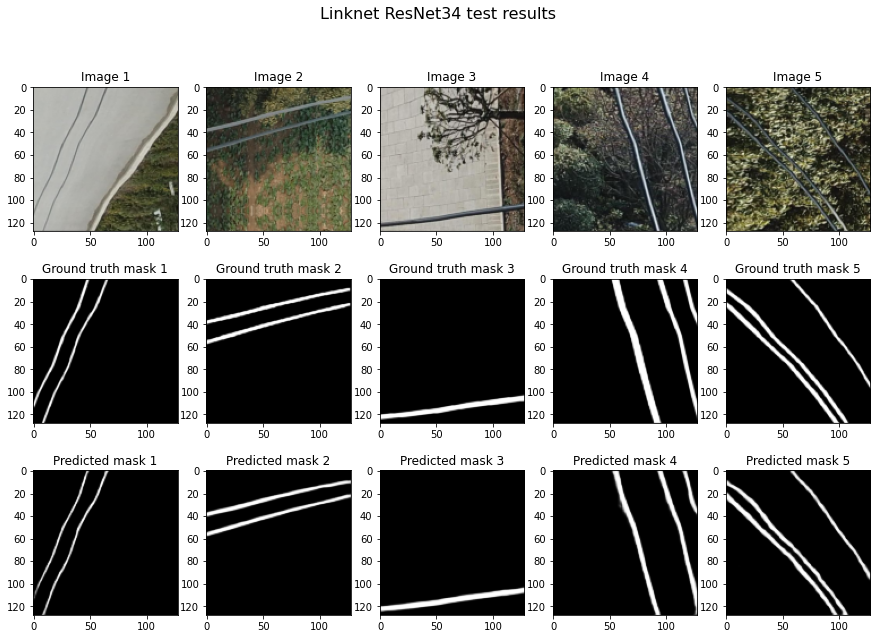

In [85]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_resnet[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_resnet[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_resnet[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_resnet[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_resnet[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('Linknet ResNet34 test results', fontsize=16)
plt.show()

In [86]:
resnet_ious = []

for i in thresholds:
  cpy = tst_resnet.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  resnet_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [87]:
threshold = thresholds[np.argmax(resnet_ious)]

In [88]:
af_tst_resnet = tst_resnet.copy()
af_tst_resnet[af_tst_resnet >= threshold ] = 1
af_tst_resnet[af_tst_resnet < threshold ] = 0

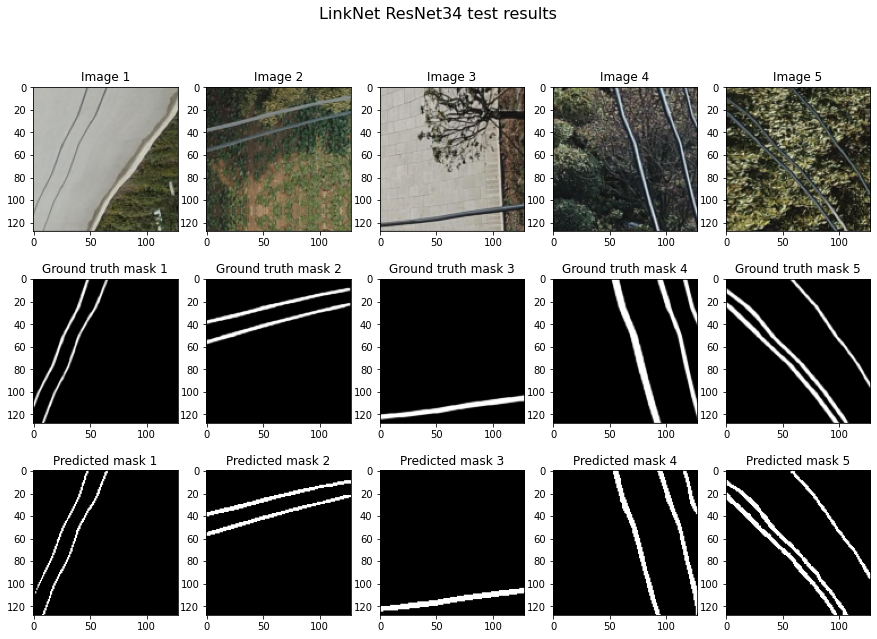

In [89]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_resnet[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_resnet[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_resnet[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_resnet[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_resnet[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('LinkNet ResNet34 test results', fontsize=16)
plt.show()

In [90]:
print('IoU score for the ResNet 34  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_resnet))))

IoU score for the ResNet 34  backbone is: 0.7153413891792297 


### Inception V3

In [91]:
BACKBONE = 'inceptionv3'

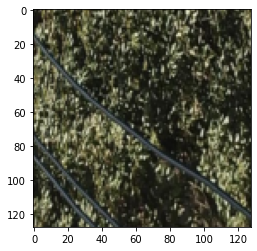

In [92]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [93]:
model_linknet_inception = 'models/linknet_inception'

In [94]:
num_thresholds = 15
model = sm.Linknet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_linknet_inception, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

Epoch 1/50
75/75 [==============================] - 38s 362ms/step - loss: 0.2928 - auc: 0.8120 - val_loss: 14.2839 - val_auc: 0.5907

Epoch 00001: val_loss improved from inf to 14.28393, saving model to models/linknet_inception
Epoch 2/50
75/75 [==============================] - 25s 333ms/step - loss: 0.0840 - auc: 0.9758 - val_loss: 0.1936 - val_auc: 0.9106

Epoch 00002: val_loss improved from 14.28393 to 0.19359, saving model to models/linknet_inception
Epoch 3/50
75/75 [==============================] - 25s 334ms/step - loss: 0.0630 - auc: 0.9857 - val_loss: 0.0803 - val_auc: 0.9676

Epoch 00003: val_loss improved from 0.19359 to 0.08031, saving model to models/linknet_inception
Epoch 4/50
75/75 [==============================] - 25s 334ms/step - loss: 0.0572 - auc: 0.9897 - val_loss: 0.0597 - val_auc: 0.9864

Epoch 00004: val_loss improved from 0.08031 to 0.05971, saving model to models/linknet_inception
Epoch 5/50
75/75 [==============================] - 25s 334ms/step - loss: 0.

In [95]:
# model.load_weights(model_linknet_inception)

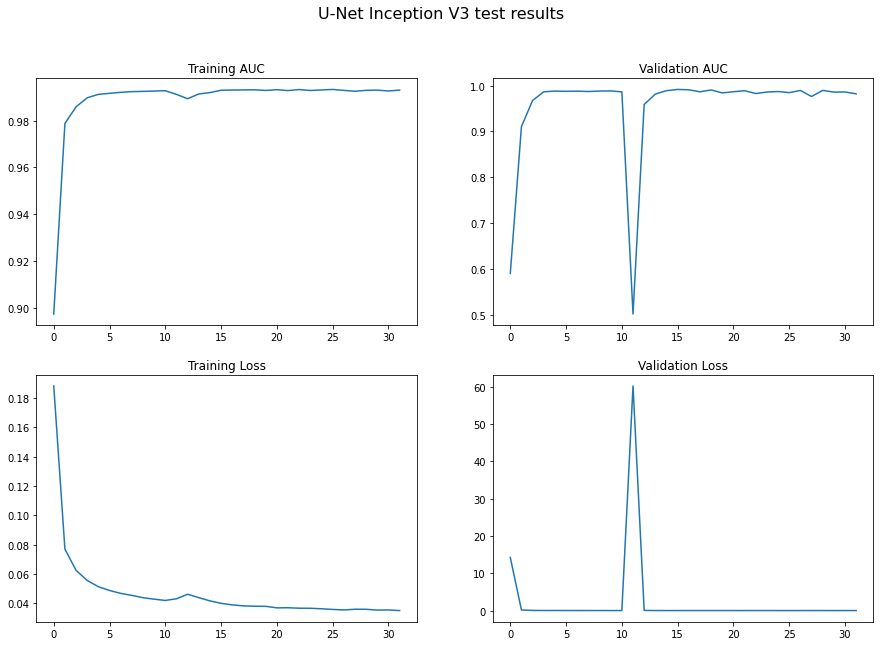

In [96]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('LinkNet Inception V3 test results', fontsize=16)
plt.show()

In [97]:
tst_inception = model.predict(val_x)

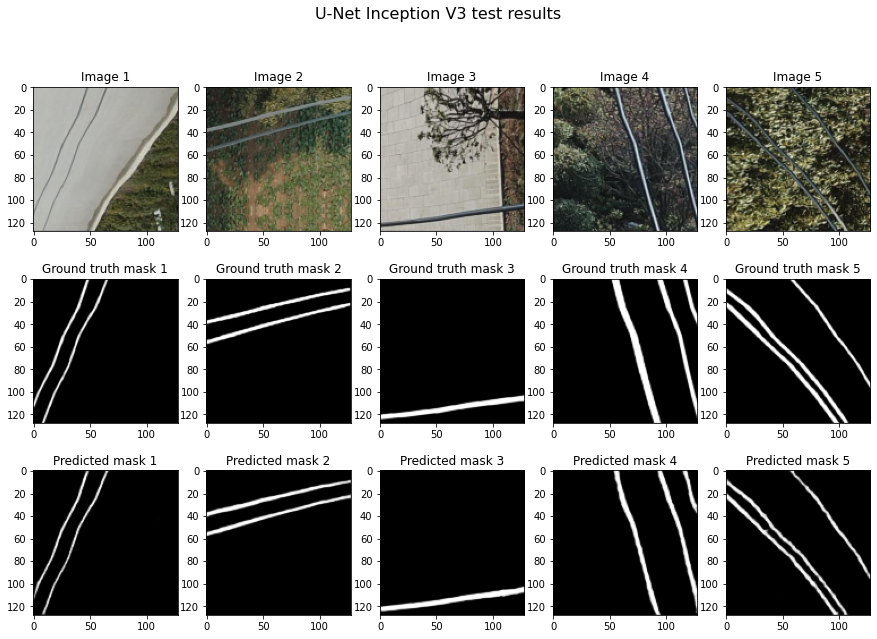

In [98]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('LinkNet Inception V3 test results', fontsize=16)
plt.show()

In [99]:
inception_ious = []

for i in thresholds:
  cpy = tst_inception.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  inception_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [100]:
threshold = thresholds[np.argmax(inception_ious)]

In [101]:
af_tst_inception = tst_inception.copy()
af_tst_inception[af_tst_inception >= threshold ] = 1
af_tst_inception[af_tst_inception < threshold ] = 0

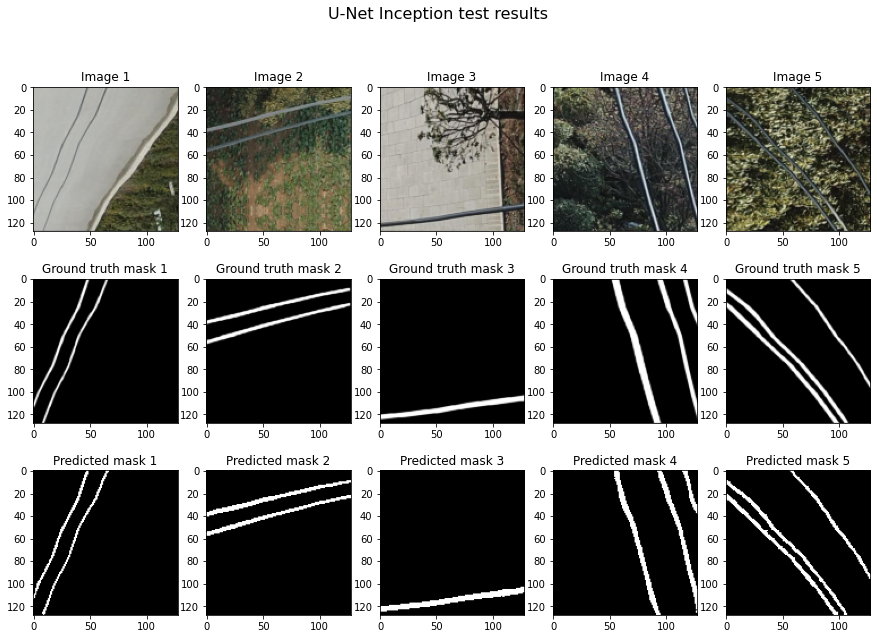

In [102]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('LinkNet Inception test results', fontsize=16)
plt.show()

In [103]:
print('IoU score for the ResNet 34  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_inception))))

IoU score for the ResNet 34  backbone is: 0.7189125418663025 


#### Conclusion about U-Net model
Best backbone: **Inception V3** \\
Reason: Higher IoU

# General conclusion for PLDU data set:
Use the U-Net model with inception V3 Backbone